In [1]:
# Import libraries 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# initial parameters
epochs = 35
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

In [3]:
data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'./data/Gender-Detection/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [5]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) 
testY = to_categorical(testY, num_classes=2)

# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [6]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])




In [7]:
# train the model
history = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

Epoch 1/35
28/28 [==============================] - 10s 218ms/step - loss: 0.7751 - accuracy: 0.7086 - val_loss: 0.9975 - val_accuracy: 0.4935
Epoch 2/35
28/28 [==============================] - 5s 174ms/step - loss: 0.5031 - accuracy: 0.8007 - val_loss: 1.1885 - val_accuracy: 0.4935
Epoch 3/35
28/28 [==============================] - 5s 180ms/step - loss: 0.4449 - accuracy: 0.8287 - val_loss: 0.9153 - val_accuracy: 0.6234
Epoch 4/35
28/28 [==============================] - 5s 190ms/step - loss: 0.3982 - accuracy: 0.8478 - val_loss: 1.4621 - val_accuracy: 0.5281
Epoch 5/35
28/28 [==============================] - 5s 183ms/step - loss: 0.3666 - accuracy: 0.8636 - val_loss: 1.3024 - val_accuracy: 0.5065
Epoch 6/35
28/28 [==============================] - 5s 184ms/step - loss: 0.3421 - accuracy: 0.8636 - val_loss: 1.3025 - val_accuracy: 0.5130
Epoch 7/35
28/28 [==============================] - 5s 172ms/step - loss: 0.2974 - accuracy: 0.8787 - val_loss: 1.3744 - val_accuracy: 0.5065
Epoch

In [8]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (16.0, 10.0)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

def plot_accuracy(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    plt.plot(training_accuracy,'r',linewidth=3.0)
    plt.plot(validation_accuracy,'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()

def plot_loss(history):
  
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']
  plt.plot(training_loss,'m',linewidth=3.0)
  plt.plot(validation_loss,'c',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

    
        

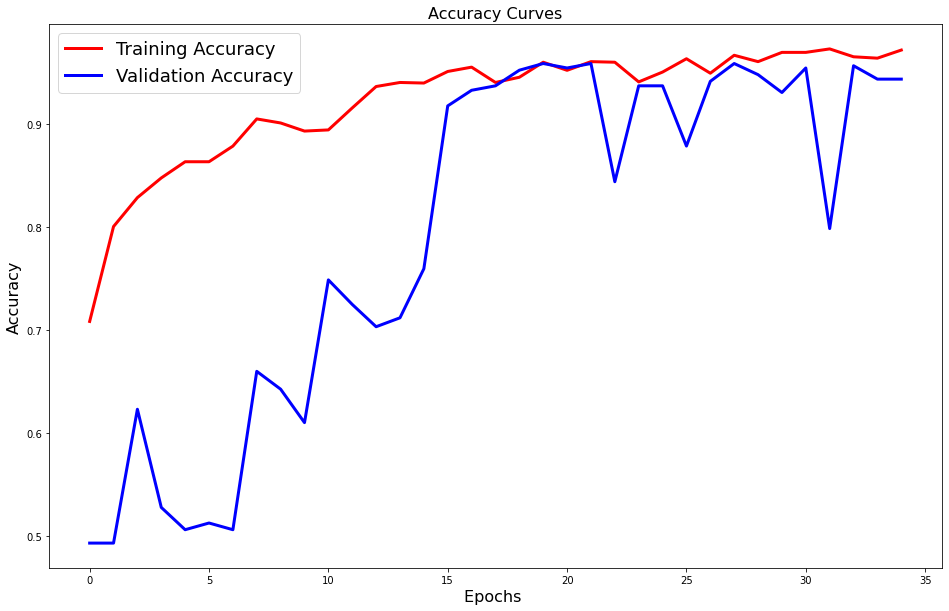

In [9]:
plot_accuracy(history)

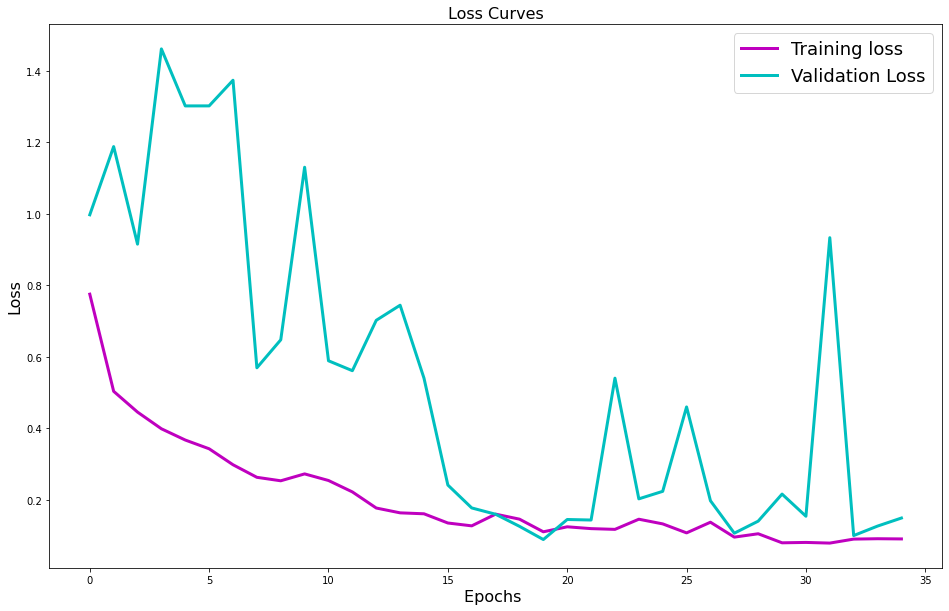

In [10]:
plot_loss(history)

In [11]:
model.save('./Model/GenderV2.h5')